# Gmail Explorer Imputer

###### By [nickesc](https://github.com/nickesc) / [N. Escobar](https://nickesc.com)

Now that we have data from the last notebook, we can start to analyze it! The first thing we need to do is load in our data:

In [1]:
import os
import csv
import base64
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import datetime


from IPython.display import clear_output, display
#from ipywidgets import *
#from tkinter import Tk, filedialog
#from math import floor

In [3]:
messages = pd.read_csv("../messages.csv")
messages.head()


,id,received,delivered-to,to,from,subject,labels,sizeEstimate,threadId,internalDate,body
0,17f1070e03e35958,by 2002:a67:f25a:0:0:0:0:0 with SMTP id y26csp...,nickesc.media@gmail.com,nickesc.media@gmail.com,Reddit <noreply@redditmail.com>,"""S14E07 - The Daytona Wind [Live/Reaction Pos...""","['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",99627,17f1070e03e35958,1645248306000,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
1,17f0b56c090c9862,by 2002:a67:f25a:0:0:0:0:0 with SMTP id y26csp...,nickesc.media@gmail.com,nickesc.media@gmail.com,Reddit <noreply@redditmail.com>,"""This mummy tomb, which has been sealed for 2...""","['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",105088,17f0b56c090c9862,1645162708000,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
2,17f062e5d45a24b2,by 2002:a67:f25a:0:0:0:0:0 with SMTP id y26csp...,nickesc.media@gmail.com,nickesc.media@gmail.com,Reddit <noreply@redditmail.com>,"""Report: Kyler Murray Told Colt McCoy 'I'm Do...""","['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",109995,17f062e5d45a24b2,1645076175000,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
3,17f0102f8d3f357a,by 2002:a67:f25a:0:0:0:0:0 with SMTP id y26csp...,nickesc.media@gmail.com,nickesc.media@gmail.com,Reddit <noreply@redditmail.com>,"""[PFT] Cooper Kupp received one vote for regu...""","['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",103863,17f0102f8d3f357a,1644989445000,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
4,17efbd7aa4817a39,by 2002:a67:f25a:0:0:0:0:0 with SMTP id y26csp...,nickesc.media@gmail.com,nickesc.media@gmail.com,Reddit <noreply@redditmail.com>,"""That ""I ain't trynna catch a diss track"" hov...""","['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",110380,17efbd7aa4817a39,1644902721000,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...


<AxesSubplot:>

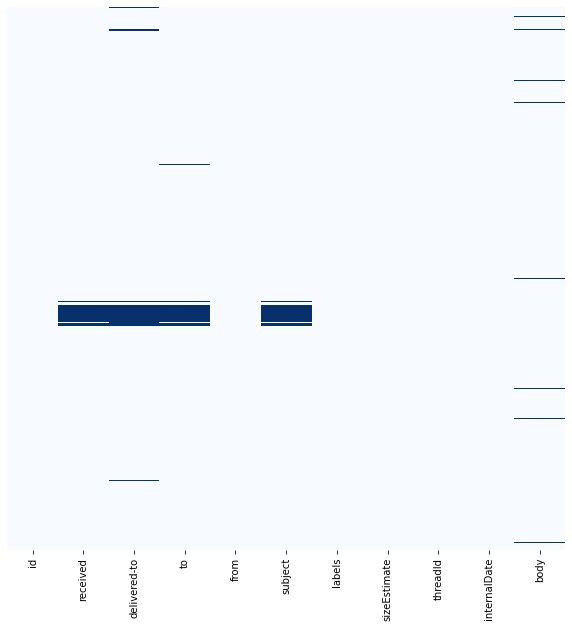

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
display(sns.heatmap(messages.isnull(),yticklabels=False, cbar=False,
           cmap="Blues",ax=ax))

In [5]:
inboxes = pd.DataFrame()
chats = pd.DataFrame()
emails = pd.DataFrame()

## Turning our data into something useful

Now, we can start to actually look at the data and come to some conclusions. First though, even though we made the data set, we still need to do some cleanup. It's still, for the most part, the same way we got it from google, just put together a little nicer. We haven't really had to fill in or change the data yet. 

The `internalDate` is useful for tracking trends over time, but doesn't really tell us when it actually happened, so we need to convert that to `dateTime`. We also want to adjust our `from` column, which tells us the name and the address, and we really only want the address, because not all senders have a name. We also need to take care of all the `NaN`s in the data, which mostly come from weird or missed headers, but are mostly fixable too.

In [6]:
def convertTime(epochtime):
    thetime = datetime.datetime.fromtimestamp(epochtime/1000)
    return(thetime)
def convertYear(epochtime):
    thetime = datetime.datetime.fromtimestamp(epochtime/1000)
    return(thetime.year)
def convertMonth(epochtime):
    thetime = datetime.datetime.fromtimestamp(epochtime/1000)
    return(thetime.month)
def convertDay(epochtime):
    thetime = datetime.datetime.fromtimestamp(epochtime/1000)
    return(thetime.day)

nans=[]
def convertAddress(string):
    try:
        address = string.split('<')[-1].split('>')[0]
    except:
        nans.append(string)
        address = str(string)
    return address
def convertLabels(labels):
    string=""
    x=0
    for label in labels:
        if x==0:
            string=str(label)
            x+=1
        else:
            string=string+","+str(label)
    return labels
    
    #return labels.replace("'", "").strip('][').split(', ')


inboxes['id'] = messages["id"]
inboxes['threadId'] = messages["threadId"]
inboxes["from"] = messages["from"].apply(convertAddress)
inboxes['delivered'] = messages["delivered-to"]
inboxes['to'] = messages["to"].apply(convertAddress)
inboxes['internalDate'] = messages["internalDate"]
inboxes["dateTime"] = messages["internalDate"].apply(convertTime)
inboxes["year"] = messages["internalDate"].apply(convertYear)
inboxes["month"] = messages["internalDate"].apply(convertMonth)
inboxes["day"] = messages["internalDate"].apply(convertDay)
inboxes["labels"] = messages["labels"].apply(convertLabels)
inboxes['sizeEstimate'] = messages["sizeEstimate"]
inboxes['subject'] = messages["subject"]
inboxes['body'] = messages['body']

inboxes["labels"].describe()

count                                92194
unique                                  81
top       ['CATEGORY_PROMOTIONS', 'INBOX']
freq                                 44386
Name: labels, dtype: object

### Received vs. Chats vs. Drafts vs. Sent

Before we handle `NaN`s, we're going to split off the Google Hangouts chats. These, though not really emails, still appear as messages in your inbox. The problem is that they, in addition to drafts and sent emails, throw off a lot of the other metrics, especially because there are so many chats, including the onces I sent. The chats lack two of the addresses addresses or a subject for the most part, making them confusing blanks spots in the table (the big hole in the center on the heatmap at the top). Some of them you could figure out, but the ones I sent only have my name attached, not who I sent them to, so I decided to skip them altogether, since they're already peripheral. Drafts and sent messages, however, we can still figure out the missing information in the same way we do received messages, so we'll leave those in for now. 

In [7]:
chats = inboxes[(inboxes['labels'].str.contains('CHAT')) == True].copy(deep=True)
emails = inboxes[(inboxes['labels'].str.contains('CHAT')) == False].copy(deep=True)
display(chats,emails)

,id,threadId,from,delivered,to,internalDate,dateTime,year,month,day,labels,sizeEstimate,subject,body
118,17ce8fff3791bda0,17ce8fff3791bda0,nickesc.media@gmail.com,NaN,nan,1635996660601,2021-11-03 23:31:00.601,2021,11,3,['CHAT'],100,NaN,TGV0JiMzOTtzIGNoYXQgb24gSGFuZ291dHMh
40479,15ecbd48cdcd6fd9,15ecbd48cdcd6fd9,+17134928662@gmail.com,josephgoodman85@gmail.com,josephgoodman85@gmail.com,1506658258000,2017-09-29 00:10:58.000,2017,9,29,['CHAT'],1941,Chat with +17134928662@gmail.com,PGNvbjpjb252ZXJzYXRpb24geG1sbnM6Y29uPSJnb29nbG...
48257,1572f5d57668f9af,1572f5d21980ff4a,josephgoodman85@gmail.com,NaN,nan,1473968428902,2016-09-15 15:40:28.902,2016,9,15,['CHAT'],100,NaN,NaN
48258,1572f5d3e7d52fac,1572f5d21980ff4a,josephgoodman85@gmail.com,NaN,nan,1473968422525,2016-09-15 15:40:22.525,2016,9,15,['CHAT'],100,NaN,NaN
48259,1572f5d32bde0279,1572f5d21980ff4a,josephgoodman85@gmail.com,NaN,nan,1473968419517,2016-09-15 15:40:19.517,2016,9,15,['CHAT'],100,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54518,13d2c4b7b47ae3d6,13d2c4b7b47ae3d6,stavem@gmail.com,josephgoodman85@gmail.com,josephgoodman85@gmail.com,1362247730000,2013-03-02 13:08:50.000,2013,3,2,['CHAT'],1538,Chat with S Em,PGNvbjpjb252ZXJzYXRpb24geG1sbnM6Y29uPSJnb29nbG...
54520,13d2849215426742,13d2849215426742,stavem@gmail.com,josephgoodman85@gmail.com,josephgoodman85@gmail.com,1362180514000,2013-03-01 18:28:34.000,2013,3,1,['CHAT'],1534,Chat with S Em,PGNvbjpjb252ZXJzYXRpb24geG1sbnM6Y29uPSJnb29nbG...
54522,13cde6bb4b7af503,13cde6bb4b7af503,mosheahron@gmail.com,josephgoodman85@gmail.com,josephgoodman85@gmail.com,1360941266000,2013-02-15 10:14:26.000,2013,2,15,['CHAT'],1417,Chat with Matthew Paulson,PGNvbjpjb252ZXJzYXRpb24geG1sbnM6Y29uPSJnb29nbG...
54530,13c87691aedc2062,13c8744e8652bdc3,stavem@gmail.com,josephgoodman85@gmail.com,josephgoodman85@gmail.com,1359481478000,2013-01-29 12:44:38.000,2013,1,29,['CHAT'],0,Chat with S Em,PGNvbjpjb252ZXJzYXRpb24geG1sbnM6Y29uPSJnb29nbG...


,id,threadId,from,delivered,to,internalDate,dateTime,year,month,day,labels,sizeEstimate,subject,body
0,17f1070e03e35958,17f1070e03e35958,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1645248306000,2022-02-19 00:25:06,2022,2,19,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",99627,"""S14E07 - The Daytona Wind [Live/Reaction Pos...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
1,17f0b56c090c9862,17f0b56c090c9862,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1645162708000,2022-02-18 00:38:28,2022,2,18,"['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",105088,"""This mummy tomb, which has been sealed for 2...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
2,17f062e5d45a24b2,17f062e5d45a24b2,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1645076175000,2022-02-17 00:36:15,2022,2,17,"['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",109995,"""Report: Kyler Murray Told Colt McCoy 'I'm Do...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
3,17f0102f8d3f357a,17f0102f8d3f357a,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1644989445000,2022-02-16 00:30:45,2022,2,16,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",103863,"""[PFT] Cooper Kupp received one vote for regu...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
4,17efbd7aa4817a39,17efbd7aa4817a39,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1644902721000,2022-02-15 00:25:21,2022,2,15,"['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",110380,"""That ""I ain't trynna catch a diss track"" hov...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92189,15a1e546ba6f3c75,15a1e546ba6f3c75,noreply@creativemarket.com,nickesc.gd@gmail.com,nickesc.gd@gmail.com,1486566329000,2017-02-08 10:05:29,2017,2,8,"['CATEGORY_PROMOTIONS', 'INBOX']",181558,"All New Fonts, Graphics, Templates & More ✨",LS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS...
92190,15a1cdf13ff2d02e,15a1cdf13ff2d02e,newsletter@mightydeals.com,nickesc.gd@gmail.com,nickesc.gd@gmail.com,1486542716000,2017-02-08 03:31:56,2017,2,8,"['CATEGORY_PROMOTIONS', 'INBOX']",44040,Premium Vector Bundle with 500 Design Elements,U3RhcnQgdGhlIGxvdmUgc2Vhc29uIHdpdGggYSBicmFuZC...
92191,15a1bdd95e066d41,15a1bdd95e066d41,info@graphicpear.com,nickesc.gd@gmail.com,nickesc.gd@gmail.com,1486526189000,2017-02-07 22:56:29,2017,2,7,"['CATEGORY_PROMOTIONS', 'INBOX']",4858,Your membership confirmation for Graphic Pear,PHA-VGhhbmsgeW91IGZvciB5b3VyIG1lbWJlcnNoaXAgdG...
92192,15a1bd9fae046422,15a1bd9fae046422,info@webdesignerdepot.com,nickesc.gd@gmail.com,nickesc.gd@gmail.com,1486525954000,2017-02-07 22:52:34,2017,2,7,"['CATEGORY_UPDATES', 'INBOX']",2969,Your Webdesigner Depot download,SGVsbG8sPGJyIC8-PGJyIC8-DQpIZXJlIGlzIHRoZSBsaW...


<AxesSubplot:>

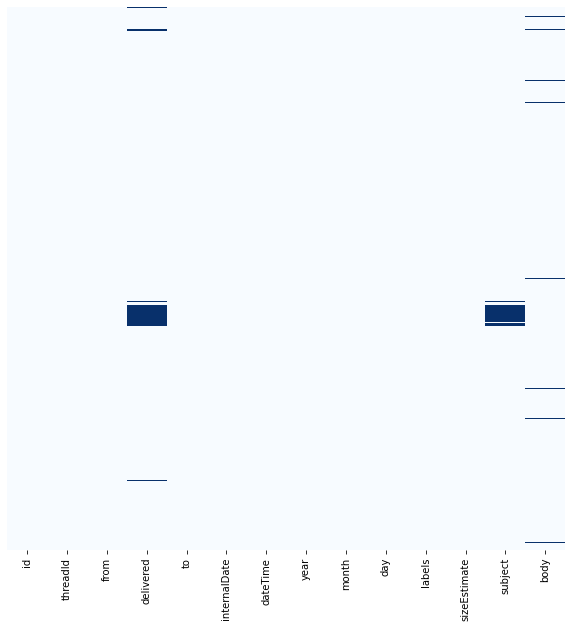

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
display(sns.heatmap(inboxes.isnull(),yticklabels=False, cbar=False,
           cmap="Blues",ax=ax))

### Missing Values

Then there are a lot of seemingly random missing values. Mostly, they're one of the three addresses -- `from`,`delivered` and `to`. The `from` address tells you the source, the `to` address is who it was addressed to, and the `delivered` address is the email it was delivered to. The strangest, by far, is that for some reason between August 2019 and April 2020, the World Wild Life Fund was emailing me from an account without any address attached to it. The email seemed  like it was coming out of no where on the table, but I managed to find the subjects of the emails in the Gmail GUI and match them with the sender. Those are the only emails that I had track down the sender, otherwise I could fill pretty easily the `to` and `delivered` columns using each other, as they're almost always the same thing.

<AxesSubplot:>

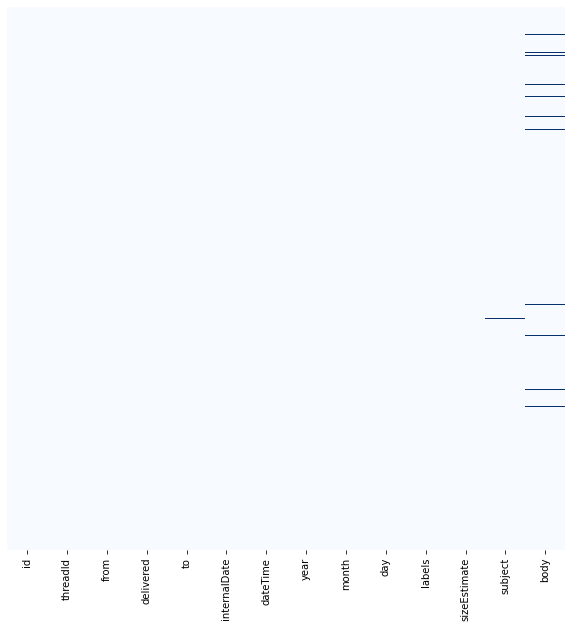

In [9]:
emails.loc[(emails['from'] == "nan") & (emails["subject"]!=""), 'from'] = 'ecomments@wwwfus.org'
#emails.loc[(emails['labels'].str.contains('SENT')) == True, 'delivered'] = '???'
emails.loc[(emails['labels'].str.contains('DRAFT')) == True, 'delivered'] = '{{not delivered}}'
#emails.loc[(emails['labels'].str.contains('DRAFT') & emails['to']=="nan") == True, 'to'] = '{{not addressed}}'
emails['to']=np.where((emails['labels'].str.contains('DRAFT') & emails['to']==np.NaN) == True,emails['delivered'],emails['to'])
emails["delivered"] = np.where((emails['labels'].str.contains('SENT')) == True, emails["to"], emails["delivered"])
fig, ax = plt.subplots(figsize=(10,10))
display(sns.heatmap(emails.isnull(),yticklabels=False, cbar=False,
           cmap="Blues",ax=ax))

<AxesSubplot:>

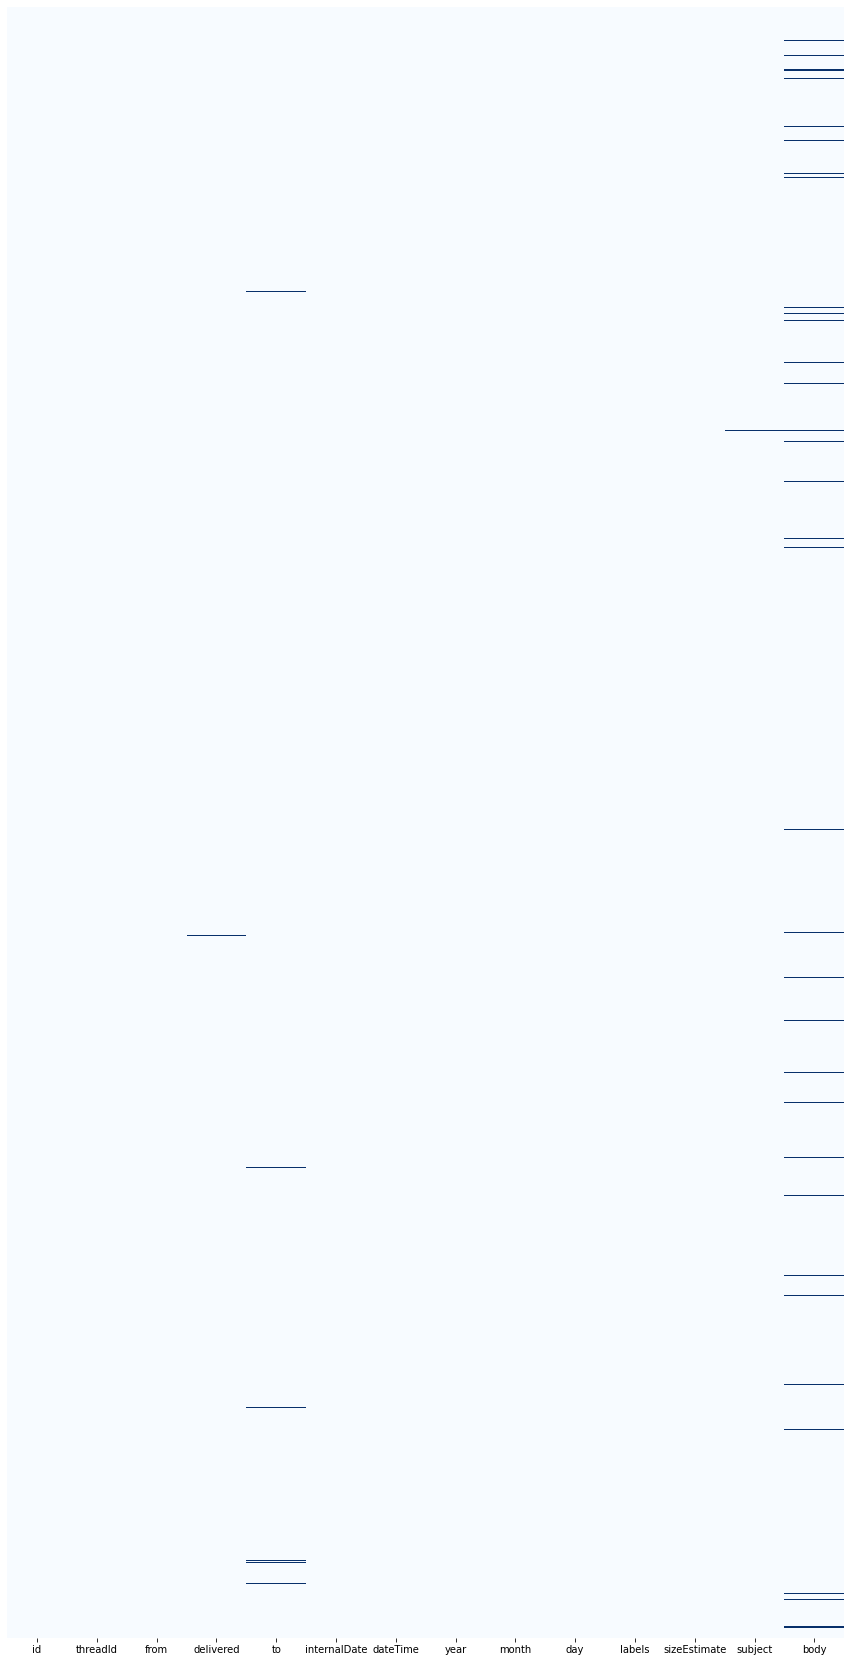

In [10]:
emails.replace("nan",np.NaN, inplace=True)
emails.replace("",np.NaN, inplace=True)
emails.sort_values("delivered")
fig, ax = plt.subplots(figsize=(15,30))
display(sns.heatmap(emails.isnull(),yticklabels=False, cbar=False,
           cmap="Blues",ax=ax))

In [11]:
emails.sort_values("to")

,id,threadId,from,delivered,to,internalDate,dateTime,year,month,day,labels,sizeEstimate,subject,body
50537,14c709060c613284,14c708fdfc50635f,josephgoodman85@gmail.com,2018class.nines@blogger.com,2018class.nines@blogger.com,1427817652000,2015-03-31 12:00:52,2015,3,31,['SENT'],2186634,Hindu Diety,NaN
3845,179edbf9afc73f27,179edbf9afc73f27,nescobar@oxy.edu,6577x25j@hpeprint.com,6577x25j@hpeprint.com,1623191414000,2021-06-08 18:30:14,2021,6,8,['SENT'],6418864,klhsdgf,NaN
45327,15a80e5210a8bfdc,15a807a3cb9f51dd,Elisabeth.Escobar@marriott.com,josephgoodman85@gmail.com,ADunn@cesjds.org,1488221182000,2017-02-27 13:46:22,2017,2,27,"['IMPORTANT', 'CATEGORY_PERSONAL', 'INBOX']",18867,RE: Shir Madness: Looking ahead!,SGkgTXIuIER1bm4sDQoNCk5pY29sYXMgRXNjb2JhciBpcy...
51302,1481772b29dbb278,1481772b29dbb278,josephgoodman85@gmail.com,ALuther@cesjds.org,ALuther@cesjds.org,1409142662000,2014-08-27 08:31:02,2014,8,27,['SENT'],707261,Class Page,SSBoYXZlIGxvb2tlZCBhdCB0aGUgcGFnZSwgYW5kIGhlcm...
50536,14c710087f14c5fc,14c70ff8084c97e0,josephgoodman85@gmail.com,Aaron.Liss@cesjds.org,Aaron.Liss@cesjds.org,1427825001000,2015-03-31 14:03:21,2015,3,31,"['IMPORTANT', 'SENT']",1898188,Reflections thing,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91375,1606e805c9187519,1606e805c9187519,ecomments@wwwfus.org,nickesc.gd@gmail.com,NaN,1513681749000,2017-12-19 06:09:09,2017,12,19,"['CATEGORY_PROMOTIONS', 'INBOX']",26603,NaN,RnJlZSBzaGlwcGluZyogb24gcG9sYXIgYmVhciBhZG9wdG...
91388,1606429b0499730c,1606429b0499730c,ecomments@wwwfus.org,nickesc.gd@gmail.com,NaN,1513508883000,2017-12-17 06:08:03,2017,12,17,"['CATEGORY_PROMOTIONS', 'INBOX']",26679,NaN,RnJlZSBzaGlwcGluZyogb24gYWRvcHRpb25zLCBhcHBhcm...
91404,16056134a64bde29,16056134a64bde29,ecomments@wwwfus.org,nickesc.gd@gmail.com,NaN,1513272649000,2017-12-14 12:30:49,2017,12,14,"['CATEGORY_PROMOTIONS', 'INBOX']",23825,NaN,V2UgY2FuJ3QgcHJvdGVjdCBhbmltYWxzLS1vciBhbnkgbG...
91416,1604bc1b07faaa57,1604bc1b07faaa57,ecomments@wwwfus.org,nickesc.gd@gmail.com,NaN,1513099533000,2017-12-12 12:25:33,2017,12,12,"['CATEGORY_PROMOTIONS', 'INBOX']",25721,NaN,VGhlc2UgdGhyZWUgd2lsZGxpZmUgd2lucyBhcmUganVzdC...


In [12]:
#emails["delivered"] = np.where((emails['delivered'] == np.NaN), emails["delivered"], emails["to"])
emails.delivered.fillna(emails.to, inplace=True)
emails.to.fillna(emails.delivered, inplace=True)
emails.sort_values("delivered")


,id,threadId,from,delivered,to,internalDate,dateTime,year,month,day,labels,sizeEstimate,subject,body
50537,14c709060c613284,14c708fdfc50635f,josephgoodman85@gmail.com,2018class.nines@blogger.com,2018class.nines@blogger.com,1427817652000,2015-03-31 12:00:52,2015,3,31,['SENT'],2186634,Hindu Diety,NaN
3845,179edbf9afc73f27,179edbf9afc73f27,nescobar@oxy.edu,6577x25j@hpeprint.com,6577x25j@hpeprint.com,1623191414000,2021-06-08 18:30:14,2021,6,8,['SENT'],6418864,klhsdgf,NaN
51302,1481772b29dbb278,1481772b29dbb278,josephgoodman85@gmail.com,ALuther@cesjds.org,ALuther@cesjds.org,1409142662000,2014-08-27 08:31:02,2014,8,27,['SENT'],707261,Class Page,SSBoYXZlIGxvb2tlZCBhdCB0aGUgcGFnZSwgYW5kIGhlcm...
50536,14c710087f14c5fc,14c70ff8084c97e0,josephgoodman85@gmail.com,Aaron.Liss@cesjds.org,Aaron.Liss@cesjds.org,1427825001000,2015-03-31 14:03:21,2015,3,31,"['IMPORTANT', 'SENT']",1898188,Reflections thing,NaN
50685,14c2df909bbe478d,14c2df8d62c9e0f8,josephgoodman85@gmail.com,Aaron.Liss@cesjds.org,Aaron.Liss@cesjds.org,1426700437000,2015-03-18 13:40:37,2015,3,18,['SENT'],648,Wear Sunscreen,aHR0cHM6Ly9tLnlvdXR1YmUuY29tL3dhdGNoP3Y9c1RKN0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,17ccdeca050b14f3,17cc93f8c563bc27,nescobar@oxy.edu,{{not delivered}},jeffreymiller@oxy.edu,1635542408000,2021-10-29 17:20:08,2021,10,29,['DRAFT'],1051,Registration PIN letter,SGkgSmVmZiwNCg0KSSBkb27igJl0IHRoaW5rIEnigJl2ZS...
84842,16b6db70a82d4462,16b6db4967966902,nickesc.gd@gmail.com,{{not delivered}},jenlouisehumphreys@gmail.com,1560913840000,2019-06-18 23:10:40,2019,6,18,['DRAFT'],2306,Re: CPR thingy,T24gSnVuIDE4LCAyMDE5LCAxMTowOSBQTSAtMDQwMCwgSm...
3279,17b9f29954d1ee97,17b9e9993030b370,nescobar@oxy.edu,{{not delivered}},justinnhli@oxy.edu,1630453746000,2021-08-31 19:49:06,2021,8,31,['DRAFT'],924,Senior Seminar Override,SGkgSnVzdGluLA0KSXMgdGhlcmUgYW55IGNoYW5jZSB5b3...
4735,178843e10007605f,17882113ef762db0,nescobar@oxy.edu,{{not delivered}},justinnhli@oxy.edu,1617126363000,2021-03-30 13:46:03,2021,3,30,['DRAFT'],4075,Re: Alternate Format Project Proposal Feedback,SSBwcm9iYWJseSBzaG91bGQgaGF2ZSBleHBhbmRlZCBhIG...


Next we fill the empty subject and body cells with a value to indicate they're empty, and lower all the addresses to be sure they're consistent when we're comparing them.

In [13]:
emptyBody=base64.urlsafe_b64encode("{{empty message body}}".encode('utf-8'))
emptySubject="{{no subject}}"

emails.replace("undisclosed-recipients:;","{{undisclosed-recipients}}")

def lowerIt(x):
    return x.lower()

emails["from"].apply(lowerIt)
emails["delivered"].apply(lowerIt)
emails["to"].apply(lowerIt)

emails["body"].fillna(emptyBody, inplace = True)
emails["subject"].fillna(emptySubject, inplace = True)

<AxesSubplot:>

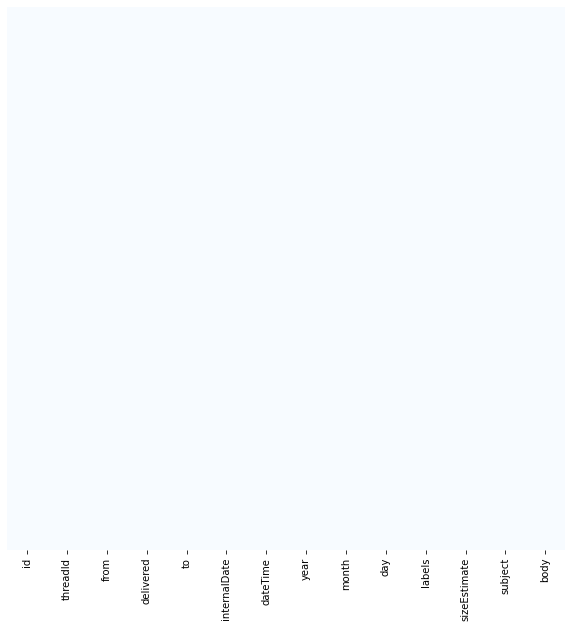

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
display(sns.heatmap(emails.sort_values("delivered").isnull(),yticklabels=False, cbar=False,
           cmap="Blues",ax=ax))
nans=emails[emails['delivered'].isnull()].index.tolist()

### Exporting the Data

In [15]:
sent = emails[(emails['labels'].str.contains('SENT')) == True].copy(deep=True)
drafts = emails[(emails['labels'].str.contains('DRAFT')) == True].copy(deep=True)
#chats = emails[(emails['labels'].str.contains('CHAT')) == True].copy(deep=True)

recieved = emails[(emails['labels'].str.contains('SENT') == False) &  (emails['labels'].str.contains('DRAFT') == False) & (emails['labels'].str.contains('Chats') == False)].copy(deep=True)


display(recieved.head(),sent.head(), drafts.head(),chats.head())

,id,threadId,from,delivered,to,internalDate,dateTime,year,month,day,labels,sizeEstimate,subject,body
0,17f1070e03e35958,17f1070e03e35958,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1645248306000,2022-02-19 00:25:06,2022,2,19,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",99627,"""S14E07 - The Daytona Wind [Live/Reaction Pos...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
1,17f0b56c090c9862,17f0b56c090c9862,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1645162708000,2022-02-18 00:38:28,2022,2,18,"['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",105088,"""This mummy tomb, which has been sealed for 2...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
2,17f062e5d45a24b2,17f062e5d45a24b2,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1645076175000,2022-02-17 00:36:15,2022,2,17,"['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",109995,"""Report: Kyler Murray Told Colt McCoy 'I'm Do...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
3,17f0102f8d3f357a,17f0102f8d3f357a,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1644989445000,2022-02-16 00:30:45,2022,2,16,"['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']",103863,"""[PFT] Cooper Kupp received one vote for regu...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...
4,17efbd7aa4817a39,17efbd7aa4817a39,noreply@redditmail.com,nickesc.media@gmail.com,nickesc.media@gmail.com,1644902721000,2022-02-15 00:25:21,2022,2,15,"['UNREAD', 'CATEGORY_UPDATES', 'INBOX']",110380,"""That ""I ain't trynna catch a diss track"" hov...""",PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...


,id,threadId,from,delivered,to,internalDate,dateTime,year,month,day,labels,sizeEstimate,subject,body
76,17dae8fa46d72a57,17dae8fa46d72a57,nickesc.media@gmail.com,xxxxxx@xxxxxxrescobar.com,xxxxxx@xxxxxxrescobar.com,1639311189000,2021-12-12 07:13:09,2021,12,12,"['SENT', 'INBOX']",1964,New Keeper Line,QSBsaW5lIGhhcyBiZWVuIGFkZGVkIHRvIHRoZSBLZWVwZX...
77,17dae79b7b93dede,17dae79b7b93dede,nickesc.media@gmail.com,xxxxxx@xxxxxxrescobar.com,xxxxxx@xxxxxxrescobar.com,1639309751000,2021-12-12 06:49:11,2021,12,12,"['SENT', 'INBOX']",1964,New Keeper Line,QSBsaW5lIGhhcyBiZWVuIGFkZGVkIHRvIHRoZSBLZWVwZX...
81,17da920352559430,17da920352559430,nickesc.media@gmail.com,xxxxxx@xxxxxxrescobar.com,xxxxxx@xxxxxxrescobar.com,1639219999000,2021-12-11 05:53:19,2021,12,11,"['SENT', 'INBOX']",1964,New Keeper Line,QSBsaW5lIGhhcyBiZWVuIGFkZGVkIHRvIHRoZSBLZWVwZX...
82,17da91bd48e8f9c9,17da91bd48e8f9c9,nickesc.media@gmail.com,xxxxxx@xxxxxxrescobar.com,xxxxxx@xxxxxxrescobar.com,1639219713000,2021-12-11 05:48:33,2021,12,11,"['SENT', 'INBOX']",1964,New Keeper Line,QSBsaW5lIGhhcyBiZWVuIGFkZGVkIHRvIHRoZSBLZWVwZX...
83,17da91a4996032a7,17da91a4996032a7,nickesc.media@gmail.com,xxxxxx@xxxxxxrescobar.com,xxxxxx@xxxxxxrescobar.com,1639219611000,2021-12-11 05:46:51,2021,12,11,"['SENT', 'INBOX']",1964,New Keeper Line,QSBsaW5lIGhhcyBiZWVuIGFkZGVkIHRvIHRoZSBLZWVwZX...


,id,threadId,from,delivered,to,internalDate,dateTime,year,month,day,labels,sizeEstimate,subject,body
361,17ee5e1f61224f87,17eace3b9e8e15f3,nescobar@oxy.edu,{{not delivered}},alyford@oxy.edu,1644534298000,2022-02-10 18:04:58,2022,2,10,['DRAFT'],6511,Re: Studio Art Minor Declaration,SGkgUHJvZmVzc29yLA0KRG8geW91IHRoaW5rIHRoYXQgeW...
371,17ee47ada2c5e9d4,17ee47ada2c5e9d4,nescobar@oxy.edu,{{not delivered}},boscoe@oxy.edu,1644510763000,2022-02-10 11:32:43,2022,2,10,['DRAFT'],502,{{no subject}},DQo=DQo=
520,17ebe546770d30e0,17ebe07a16a1b78a,nescobar@oxy.edu,{{not delivered}},boscoe@oxy.edu,1643870709000,2022-02-03 01:45:09,2022,2,3,['DRAFT'],885,Class 2/14,SGkgUHJvZmVzc29yLA0KSSB3YW50ZWQgdG8gbGV0IHlvdS...
990,17dec9b24f9afe09,17dec9b24f9afe09,nescobar@oxy.edu,{{not delivered}},{{not delivered}},1640352130000,2021-12-24 08:22:10,2021,12,24,['DRAFT'],466,{{no subject}},DQo=DQo=
1155,17da0bf66d6a969b,17da0bf66d6a969b,nescobar@oxy.edu,{{not delivered}},atasse@oxy.edu,1639079437000,2021-12-09 14:50:37,2021,12,9,['DRAFT'],516,Returning laptop,DQo=DQo=


,id,threadId,from,delivered,to,internalDate,dateTime,year,month,day,labels,sizeEstimate,subject,body
118,17ce8fff3791bda0,17ce8fff3791bda0,nickesc.media@gmail.com,NaN,nan,1635996660601,2021-11-03 23:31:00.601,2021,11,3,['CHAT'],100,NaN,TGV0JiMzOTtzIGNoYXQgb24gSGFuZ291dHMh
40479,15ecbd48cdcd6fd9,15ecbd48cdcd6fd9,+17134928662@gmail.com,josephgoodman85@gmail.com,josephgoodman85@gmail.com,1506658258000,2017-09-29 00:10:58.000,2017,9,29,['CHAT'],1941,Chat with +17134928662@gmail.com,PGNvbjpjb252ZXJzYXRpb24geG1sbnM6Y29uPSJnb29nbG...
48257,1572f5d57668f9af,1572f5d21980ff4a,josephgoodman85@gmail.com,NaN,nan,1473968428902,2016-09-15 15:40:28.902,2016,9,15,['CHAT'],100,NaN,NaN
48258,1572f5d3e7d52fac,1572f5d21980ff4a,josephgoodman85@gmail.com,NaN,nan,1473968422525,2016-09-15 15:40:22.525,2016,9,15,['CHAT'],100,NaN,NaN
48259,1572f5d32bde0279,1572f5d21980ff4a,josephgoodman85@gmail.com,NaN,nan,1473968419517,2016-09-15 15:40:19.517,2016,9,15,['CHAT'],100,NaN,NaN


In [16]:
recieved.sort_values('internalDate').reset_index(drop=True).to_csv('imputed/recieved.csv')
sent.sort_values('internalDate').reset_index(drop=True).to_csv("imputed/sent.csv")
drafts.sort_values('internalDate').reset_index(drop=True).to_csv('imputed/drafts.csv')
chats.sort_values('internalDate').reset_index(drop=True).to_csv('imputed/chats.csv')

Finally, we pull all our various `DataFRames` together and output four `.csv` files, for recieved messages, for sent messages, for drafts, and for chats, each of which is a little different to look at.